In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pycountry_convert as pc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import utils
sb.set()

In [2]:
merged_df = pd.read_csv('merged.csv')
merged_df

,Country,year,gdp_per_capita ($),Total_Population,suicides_no,suicides/100k_pop,percentage of elderly(%),Education index,"Inflation, consumer prices (annual %)",Unemployment Rate
0,Albania,1987,796,2709600,73,2.69,2.118394,NaN,NaN,NaN
1,Albania,1988,769,2764300,63,2.28,2.123503,NaN,NaN,NaN
2,Albania,1989,833,2803100,68,2.43,2.122650,NaN,NaN,NaN
3,Albania,1992,251,2822500,47,1.67,2.217892,0.557,226.005421,30.014999
4,Albania,1993,437,2807300,73,2.60,2.261960,0.542,85.004751,25.257999
...,...,...,...,...,...,...,...,...,...,...
2316,Uzbekistan,2010,1533,25651783,1464,5.71,2.023481,0.674,NaN,5.400000
2317,Uzbekistan,2011,1767,25978049,1640,6.31,2.061810,0.681,NaN,5.000000
2318,Uzbekistan,2012,1964,26381830,1835,6.96,2.093373,0.692,NaN,4.900000
2319,Uzbekistan,2013,2150,26838924,1950,7.27,2.109556,0.699,NaN,4.900000


As the objective here is to find the factor that influences suicide rates the most, we begin with a simple Linear Model.
Since 'Country' is a category, we try to determine if the continent that the country is located in is also a factor in suicide rates.

#### Divide countries into their respective continents

In [3]:
def country2continent(given):
    country = pc.country_name_to_country_alpha2(given)
    continent = pc.country_alpha2_to_continent_code(country)
    return continent

In [4]:
values = []
for item in merged_df['Country']:
    try:
        values.append(country2continent(item))
    except:
        values.append(np.NaN)
merged_df['Continent'] = values

In [5]:
merged_df.head()

,Country,year,gdp_per_capita ($),Total_Population,suicides_no,suicides/100k_pop,percentage of elderly(%),Education index,"Inflation, consumer prices (annual %)",Unemployment Rate,Continent
0,Albania,1987,796,2709600,73,2.69,2.118394,NaN,NaN,NaN,EU
1,Albania,1988,769,2764300,63,2.28,2.123503,NaN,NaN,NaN,EU
2,Albania,1989,833,2803100,68,2.43,2.122650,NaN,NaN,NaN,EU
3,Albania,1992,251,2822500,47,1.67,2.217892,0.557,226.005421,30.014999,EU
4,Albania,1993,437,2807300,73,2.60,2.261960,0.542,85.004751,25.257999,EU


#### Using one-hot encoding to create dummy variables for categorical data (Continent)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler #to normalise data and encode categorical into numerical
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
from sklearn.linear_model import LinearRegression

y = merged_df[['suicides/100k_pop']]
transformed = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['Continent']),\
                                              ('scale', StandardScaler(), ["gdp_per_capita ($)",\
                                                                           "Education index",\
                                                                           "Unemployment Rate",\
                                                                           "Inflation, consumer prices (annual %)",\
                                                                           "percentage of elderly(%)"])],\
                                remainder='passthrough')

x = transformed.fit_transform(merged_df.iloc[:, [2, 6, 7, 8, 9, 10]])
x = imputer.fit_transform(x)
x = x[:, [2, 6, 7, 8, 9, 10]]

## Creating Linear Regression model

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

reg = LinearRegression()
model = reg.fit(x_train, y_train)
predicted = reg.predict(x_test)

print("Train Set :", y_train.shape, x_train.shape)
print("Test Set  :", y_test.shape, x_test.shape)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', reg.intercept_)
print('Coefficients of Regression \t: a = ', reg.coef_)
print()

importance = model.coef_
print("gdp_per_capita ($): \t\t\t", importance[0][0])
print("percentage of elderly(%): \t\t", importance[0][1])
print("Education index: \t\t\t", importance[0][2])
print("Inflation, consumer prices (annual %):\t", importance[0][3])
print("Unemployment Rate: \t\t\t", importance[0][4])
print("Continent:\t\t\t\t", importance[0][5])

Train Set : (1856, 1) (1856, 6)
Test Set  : (465, 1) (465, 6)
Intercept of Regression 	: b =  [8.53632431]
Coefficients of Regression 	: a =  [[ 7.70952333  1.82824705 -1.95013619  2.56280108 -0.55656481  0.35059975]]

gdp_per_capita ($): 			 7.709523325437712
percentage of elderly(%): 		 1.8282470538263103
Education index: 			 -1.9501361892957134
Inflation, consumer prices (annual %):	 2.562801080721808
Unemployment Rate: 			 -0.5565648105597001
Continent:				 0.3505997536976365


Using the normalised data:
$$Suicide/100kPop = 8.54 + 7.71 × GDP per Capita + 1.83 × Percentage of Elderly - 1.95 × Education Index + 2.56 × Inflation - 0.557 × Unemployment Rate + 0.351 × Continent$$

As we can see from this linear regression, GDP is the most significant factor, with the highest correlation. The factor with the least significance is the continent the country is in.

<AxesSubplot:>

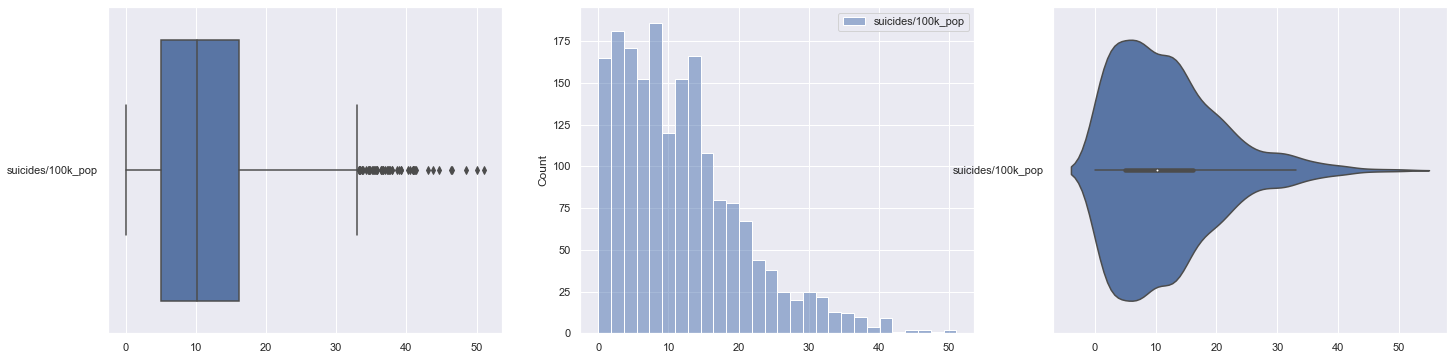

In [8]:
# Draw the distribution of Response
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = y_train, orient = "h", ax = axes[0])
sb.histplot(data = y_train, ax = axes[1])
sb.violinplot(data = y_train, orient = "h", ax = axes[2])

#### Plotting the graph and determining accuracy

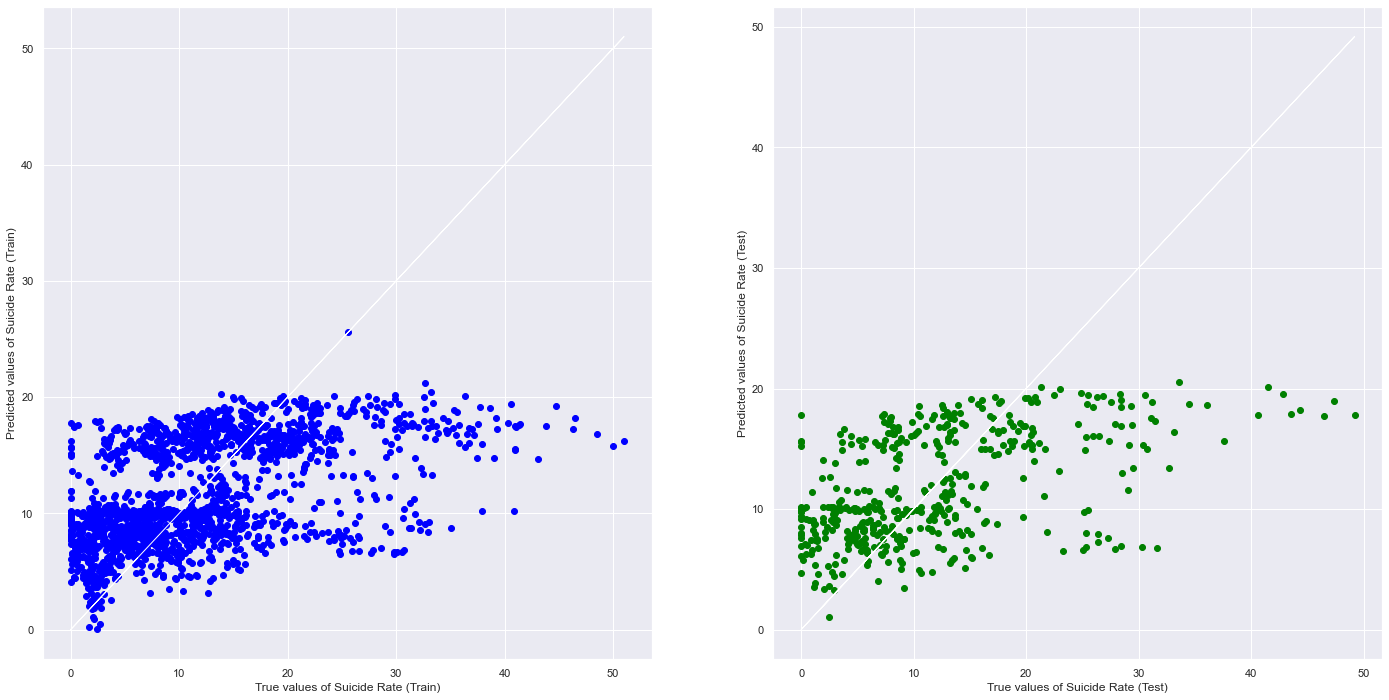

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2573121895315025
Mean Squared Error (MSE) 	: 58.05321435857907

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.26825430227757663
Mean Squared Error (MSE) 	: 62.28831666790658



In [9]:
# Predict Response corresponding to Predictors
y_train_pred = reg.predict(x_train)
y_test_pred = reg.predict(x_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of Suicide Rate (Train)")
axes[0].set_ylabel("Predicted values of Suicide Rate (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of Suicide Rate (Test)")
axes[1].set_ylabel("Predicted values of Suicide Rate (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", reg.score(x_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", reg.score(x_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [10]:
reg_score = reg.score(x, y)
reg_score

0.2596680074302443

The accuracy score is low, at 25%. This is also reflected in the graph, where all the data points are bunched together to the left, resulting in a right-skewed graph.

## Gradient Boosting

Due to the low accuracy score from the previous model, we will attempt to use averages of each country instead, and plot the average suicide rate from the average of individual factors of each country from 1990-2015. On top of that, we will try to boost the accuracy rate using gradient boosting on top of linear regression. Over here, we will use the gradient boosting regressor from scikit-learn to create a model.

In [11]:
# Gradient Boosted Regression Trees model
from sklearn.ensemble import GradientBoostingRegressor


In [12]:
average_df = pd.read_csv('average.csv')
average_df.head()

,Country,suicides/100k_pop,gdp_per_capita ($),percentage of elderly(%),Education index,"Inflation, consumer prices (annual %)",Unemployment Rate
0,Albania,3.137273,1859.045455,2.747816,0.594684,23.099078,17.873947
1,Antigua and Barbuda,0.541111,10448.185185,3.179196,0.665444,1.753879,NaN
2,Argentina,7.910645,7914.096774,4.312277,0.739000,NaN,11.297240
3,Armenia,2.475200,1886.680000,3.742146,0.683625,182.517678,11.537391
4,Aruba,8.096429,24221.642857,3.250227,NaN,3.405965,NaN


In [13]:
average_df.describe()

,suicides/100k_pop,gdp_per_capita ($),percentage of elderly(%),Education index,"Inflation, consumer prices (annual %)",Unemployment Rate
count,101.000000,101.000000,101.000000,91.000000,85.000000,86.000000
mean,10.999127,15933.270486,4.360023,0.696992,24.692055,8.604938
std,8.704041,16369.438279,2.369911,0.103224,63.240443,5.121092
min,0.000000,720.730769,0.251356,0.379231,0.477152,0.538786
25%,3.918387,4124.000000,2.301365,0.638773,2.459540,5.246327
50%,8.164516,8829.037037,3.897582,0.701286,4.874272,7.763462
75%,15.541000,25836.391304,6.336681,0.769135,10.322604,10.797250
max,40.736818,68798.387097,9.068812,0.896080,328.463281,27.692050


In [14]:
y = average_df[["suicides/100k_pop"]]
x = average_df.drop(["suicides/100k_pop"], axis=1)

Furthermore, we have to drop the country column, which is not one of the factors in regression.

In [15]:
x.drop(['Country'], axis=1, inplace=True)

In [16]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gdp_per_capita ($)                     101 non-null    float64
 1   percentage of elderly(%)               101 non-null    float64
 2   Education index                        91 non-null     float64
 3   Inflation, consumer prices (annual %)  85 non-null     float64
 4   Unemployment Rate                      86 non-null     float64
dtypes: float64(5)
memory usage: 4.1 KB


In [17]:
x.isnull().values.any()

True

A closer look shows that there are missing values in education index, inflation, and unemployment. We shall fill the missing values with the mean.

In [18]:
x["Education index"].fillna(x["Education index"].mean(), inplace=True)
x["Inflation, consumer prices (annual %)"].fillna(x["Inflation, consumer prices (annual %)"].mean(), inplace=True)
x["Unemployment Rate"].fillna(x["Unemployment Rate"].mean(), inplace=True)

In [19]:
x.isnull().values.any()

False

From here, we can continue to form our model through split train_test set again.

In [20]:
y = average_df["suicides/100k_pop"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# instantiate the model
model = GradientBoostingRegressor()

# fit the model 
model.fit(x_train, y_train)

#predicting the target value from the model for the samples
y_predict_test = model.predict(x_test)
y_predict_train = model.predict(x_train)
print(model.feature_importances_)

[0.21617347 0.33316822 0.24270856 0.12573701 0.08221275]


In [21]:
print("gdp_per_capita ($): \t\t\t", model.feature_importances_[0])
print("percentage of elderly(%): \t\t", model.feature_importances_[1])
print("Education index: \t\t\t", model.feature_importances_[2])
print("Inflation, consumer prices (annual %):\t", model.feature_importances_[3])
print("Unemployment Rate: \t\t\t", model.feature_importances_[4])

gdp_per_capita ($): 			 0.21617346516503153
percentage of elderly(%): 		 0.3331682165321471
Education index: 			 0.24270855775199537
Inflation, consumer prices (annual %):	 0.12573701174850047
Unemployment Rate: 			 0.0822127488023256


In [22]:
#computing the accuracy of the model performance
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

#computing root mean squared error (RMSE)
rmse_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_predict_test))

print("Gradient Boosted Regression Trees: Accuracy on training Data: {:.5f}".format(train_score))
print("Gradient Boosted Regression Trees: Accuracy on test Data: {:.5f}".format(test_score))
print('\nGradient Boosted Regression Trees: The RMSE of the training set is: {:.5f}', rmse_train)
print('Gradient Boosted Regression Trees: The RMSE of the testing set is: {:.5f}', rmse_test)

Gradient Boosted Regression Trees: Accuracy on training Data: 0.98279
Gradient Boosted Regression Trees: Accuracy on test Data: 0.66218

Gradient Boosted Regression Trees: The RMSE of the training set is: {:.5f} 1.1079154768202009
Gradient Boosted Regression Trees: The RMSE of the testing set is: {:.5f} 5.450247280667782


From this model, we observe a high accuracy rate on training data. However, there is a massive disparity from that and the accuracy of the test data. This means that Gradient Boosting is overfitting the data by too much.


## Logistic Regression

Due to over-fitting from the previous model, we will avoid using gradient boosting and focus on logistic regression.

This logistic regression is done using the 5 variables in average_df. A dependent variable is created for y, where if there is a suicide rate of more than the average suicide rate, it will be 1, if not then 0.

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [24]:
average_df.describe() #find mean suicide rate for logistic regression

,suicides/100k_pop,gdp_per_capita ($),percentage of elderly(%),Education index,"Inflation, consumer prices (annual %)",Unemployment Rate
count,101.000000,101.000000,101.000000,91.000000,85.000000,86.000000
mean,10.999127,15933.270486,4.360023,0.696992,24.692055,8.604938
std,8.704041,16369.438279,2.369911,0.103224,63.240443,5.121092
min,0.000000,720.730769,0.251356,0.379231,0.477152,0.538786
25%,3.918387,4124.000000,2.301365,0.638773,2.459540,5.246327
50%,8.164516,8829.037037,3.897582,0.701286,4.874272,7.763462
75%,15.541000,25836.391304,6.336681,0.769135,10.322604,10.797250
max,40.736818,68798.387097,9.068812,0.896080,328.463281,27.692050


In [25]:
average_df["new_suicides/100k_pop"] = np.where(average_df["suicides/100k_pop"]>11, 1, 0) #average is 10.999
y = average_df[["new_suicides/100k_pop"]]

We take the cleaned x variables from above in the Gradient Boosting portion
With the new y and the old x, we form the logistic model through a split train-test set again.


In [26]:
lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y.values.ravel())

In [27]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)

LogisticRegression()

In [28]:
kfold = KFold(n_splits = 10)
cross_validation_train = cross_val_score(logmodel, x_train, y_train,cv = kfold,scoring = 'accuracy')
print("The logistic model train accuracy is", cross_validation_train.mean())
cross_validation_test = cross_val_score(logmodel, x_test, y_test,cv = kfold,scoring = 'accuracy')
print("The logistic model test accuracy is", cross_validation_test.mean())

The logistic model train accuracy is 0.7625
The logistic model test accuracy is 0.7166666666666666


In [29]:
print(logmodel.intercept_)
print(logmodel.coef_)

[-0.38590177]
[[-0.15746987  0.74479286  0.91508419  0.29593636 -0.48340017]]


Using normalised data:
$$Suicide/100kPop = -0.386 - 0.158 × GDP per Capita + 0.745 × Percentage of Elderly + 0.915 × Education Index +  0.296 × Inflation - 0.483 × Unemployment Rate$$

In this model, the train accuracy is lower than the previous model, but since both train/test accuracies are similar to each other, there is less overfitting in this data.
From this model, we can deduce that the education index has the highest correlation to suicide rate. However, we are not able to deduce that increased in education level is a direct causation to suicide rates just yet.

With education as our most significant factor, we proceed to finding the relation between education and suicide rates in our policy proposal.